In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
AAPL = pd.read_csv("Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("Pre_Processed_AMZN.csv")

### Data Proprocessing

In [3]:
def Dataset(Data, Date):

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [4]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [16]:
model = Model()

In [ ]:
!conda install graphviz

In [112]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-tr

### Custom Learning Rate

In [19]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

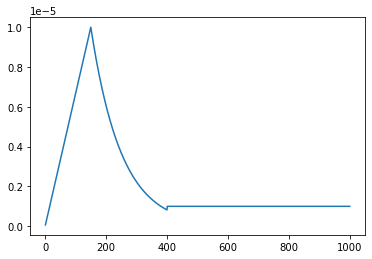

In [20]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [21]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Apple

In [22]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [23]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [24]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [25]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [52]:
AAPL_Model = Model()

In [53]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [54]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 200, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 2s 63ms/step - loss: 2316.6538 - root_mean_squared_error: 48.1316 - val_loss: 15863.8877 - val_root_mean_squared_error: 125.9519 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 20ms/step - loss: 2316.6340 - root_mean_squared_error: 48.1314 - val_loss: 15863.7070 - val_root_mean_squared_error: 125.9512 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 23ms/step - loss: 2316.5703 - root_mean_squared_error: 48.1308 - val_loss: 15863.3174 - val_root_mean_squared_error: 125.9497 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 19ms/step - loss: 2316.4617 - root_mean_squared_error: 48.1296 - val_loss: 15862.7188 - val_root_mean_squared_error: 125.9473 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 20ms/step - loss: 2316.3064 - root_mean_squared_error: 48.1280 - val_loss: 15861.9189 - val_root_mean_squared_error: 125.9441 - lr: 2.6667e-07
Epoch 6/200
9/9

9/9 [==============================] - 0s 21ms/step - loss: 2270.3416 - root_mean_squared_error: 47.6481 - val_loss: 15447.3672 - val_root_mean_squared_error: 124.2874 - lr: 2.7333e-06
Epoch 43/200
9/9 [==============================] - 0s 22ms/step - loss: 2268.2510 - root_mean_squared_error: 47.6262 - val_loss: 15428.4736 - val_root_mean_squared_error: 124.2114 - lr: 2.8000e-06
Epoch 44/200
9/9 [==============================] - 0s 23ms/step - loss: 2266.0647 - root_mean_squared_error: 47.6032 - val_loss: 15407.8311 - val_root_mean_squared_error: 124.1283 - lr: 2.8667e-06
Epoch 45/200
9/9 [==============================] - 0s 21ms/step - loss: 2263.6072 - root_mean_squared_error: 47.5774 - val_loss: 15387.9834 - val_root_mean_squared_error: 124.0483 - lr: 2.9333e-06
Epoch 46/200
9/9 [==============================] - 0s 24ms/step - loss: 2261.2820 - root_mean_squared_error: 47.5529 - val_loss: 15365.5020 - val_root_mean_squared_error: 123.9577 - lr: 3.0000e-06
Epoch 47/200
9/9 [=====

9/9 [==============================] - 0s 19ms/step - loss: 1769.4976 - root_mean_squared_error: 42.0654 - val_loss: 11373.2627 - val_root_mean_squared_error: 106.6455 - lr: 5.4667e-06
Epoch 84/200
9/9 [==============================] - 0s 19ms/step - loss: 1738.0509 - root_mean_squared_error: 41.6899 - val_loss: 11181.3984 - val_root_mean_squared_error: 105.7421 - lr: 5.5333e-06
Epoch 85/200
9/9 [==============================] - 0s 19ms/step - loss: 1707.6947 - root_mean_squared_error: 41.3243 - val_loss: 11013.7959 - val_root_mean_squared_error: 104.9466 - lr: 5.6000e-06
Epoch 86/200
9/9 [==============================] - 0s 18ms/step - loss: 1680.0220 - root_mean_squared_error: 40.9881 - val_loss: 10875.4141 - val_root_mean_squared_error: 104.2853 - lr: 5.6667e-06
Epoch 87/200
9/9 [==============================] - 0s 23ms/step - loss: 1655.1166 - root_mean_squared_error: 40.6831 - val_loss: 10767.4453 - val_root_mean_squared_error: 103.7663 - lr: 5.7333e-06
Epoch 88/200
9/9 [=====

Epoch 125/200
9/9 [==============================] - 0s 21ms/step - loss: 15.1737 - root_mean_squared_error: 3.8953 - val_loss: 36.2769 - val_root_mean_squared_error: 6.0230 - lr: 8.2667e-06
Epoch 126/200
9/9 [==============================] - 0s 20ms/step - loss: 14.6740 - root_mean_squared_error: 3.8307 - val_loss: 36.8995 - val_root_mean_squared_error: 6.0745 - lr: 8.3333e-06
Epoch 127/200
9/9 [==============================] - 0s 20ms/step - loss: 14.1806 - root_mean_squared_error: 3.7657 - val_loss: 38.0182 - val_root_mean_squared_error: 6.1659 - lr: 8.4000e-06
Epoch 128/200
9/9 [==============================] - 0s 17ms/step - loss: 13.7507 - root_mean_squared_error: 3.7082 - val_loss: 37.3816 - val_root_mean_squared_error: 6.1140 - lr: 8.4667e-06
Epoch 129/200
9/9 [==============================] - 0s 22ms/step - loss: 13.4888 - root_mean_squared_error: 3.6727 - val_loss: 40.4660 - val_root_mean_squared_error: 6.3613 - lr: 8.5333e-06
Epoch 130/200
9/9 [==========================

9/9 [==============================] - 0s 19ms/step - loss: 7.8214 - root_mean_squared_error: 2.7967 - val_loss: 28.3578 - val_root_mean_squared_error: 5.3252 - lr: 8.4366e-06
Epoch 169/200
9/9 [==============================] - 0s 20ms/step - loss: 7.7518 - root_mean_squared_error: 2.7842 - val_loss: 28.1073 - val_root_mean_squared_error: 5.3016 - lr: 8.3527e-06
Epoch 170/200
9/9 [==============================] - 0s 22ms/step - loss: 7.6973 - root_mean_squared_error: 2.7744 - val_loss: 28.1325 - val_root_mean_squared_error: 5.3040 - lr: 8.2696e-06
Epoch 171/200
9/9 [==============================] - 0s 23ms/step - loss: 7.6776 - root_mean_squared_error: 2.7708 - val_loss: 27.8220 - val_root_mean_squared_error: 5.2747 - lr: 8.1873e-06
Epoch 172/200
9/9 [==============================] - 0s 21ms/step - loss: 7.6043 - root_mean_squared_error: 2.7576 - val_loss: 26.7601 - val_root_mean_squared_error: 5.1730 - lr: 8.1058e-06
Epoch 173/200
9/9 [==============================] - 0s 19ms/ste

In [55]:
history_dict = AAPL_hist.history
loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

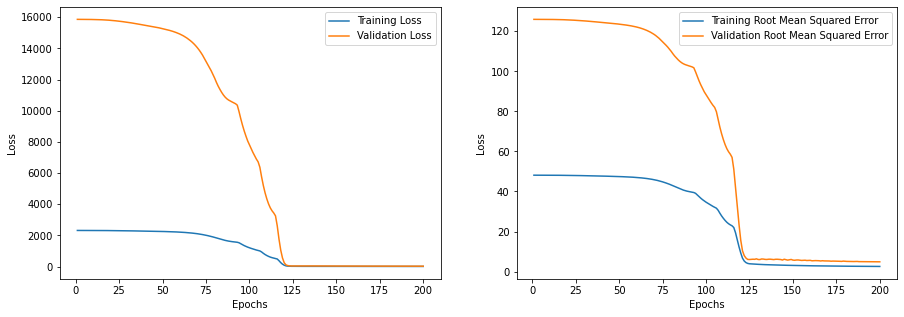

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()


### Predicting the closing stock price of Apple

In [57]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

1/1 [==============================] - 0s 361ms/step


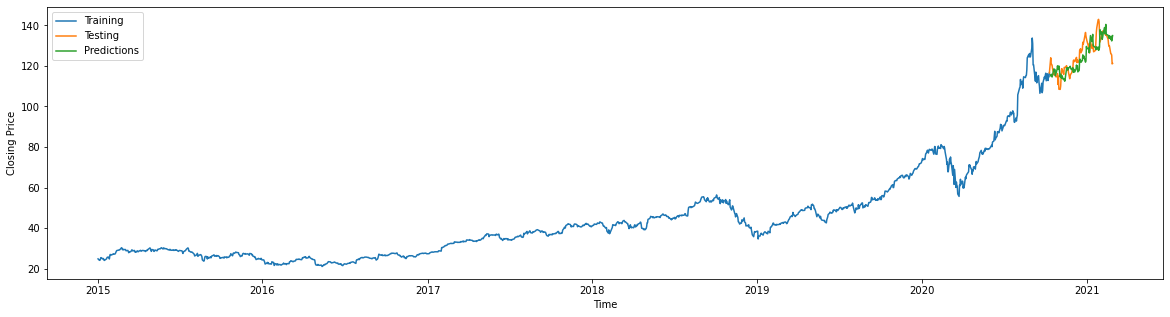

In [58]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [59]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.872865476361987
MAPE: 0.03006040335486235


# Tesla

In [60]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [61]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [62]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [63]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Model Fitting

In [64]:
TSLA_Model = Model()

In [65]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [66]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 2s 62ms/step - loss: 9957.0908 - root_mean_squared_error: 99.7852 - val_loss: 425418.7812 - val_root_mean_squared_error: 652.2413 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 18ms/step - loss: 9957.0244 - root_mean_squared_error: 99.7849 - val_loss: 425413.3750 - val_root_mean_squared_error: 652.2372 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 19ms/step - loss: 9956.8164 - root_mean_squared_error: 99.7839 - val_loss: 425402.6250 - val_root_mean_squared_error: 652.2289 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 21ms/step - loss: 9956.4639 - root_mean_squared_error: 99.7821 - val_loss: 425386.7188 - val_root_mean_squared_error: 652.2167 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 9955.9609 - root_mean_squared_error: 99.7796 - val_loss: 425366.0938 - val_root_mean_squared_error: 652.2010 - lr: 2.6667e-07
Epoch 6/20

9/9 [==============================] - 0s 22ms/step - loss: 9801.4512 - root_mean_squared_error: 99.0023 - val_loss: 417622.9688 - val_root_mean_squared_error: 646.2375 - lr: 2.7333e-06
Epoch 43/200
9/9 [==============================] - 0s 27ms/step - loss: 9791.2744 - root_mean_squared_error: 98.9509 - val_loss: 417075.8438 - val_root_mean_squared_error: 645.8140 - lr: 2.8000e-06
Epoch 44/200
9/9 [==============================] - 0s 22ms/step - loss: 9779.9209 - root_mean_squared_error: 98.8935 - val_loss: 416527.2812 - val_root_mean_squared_error: 645.3892 - lr: 2.8667e-06
Epoch 45/200
9/9 [==============================] - 0s 21ms/step - loss: 9768.5693 - root_mean_squared_error: 98.8361 - val_loss: 415930.9375 - val_root_mean_squared_error: 644.9271 - lr: 2.9333e-06
Epoch 46/200
9/9 [==============================] - 0s 22ms/step - loss: 9755.3799 - root_mean_squared_error: 98.7693 - val_loss: 415337.7188 - val_root_mean_squared_error: 644.4670 - lr: 3.0000e-06
Epoch 47/200
9/9 [

9/9 [==============================] - 0s 29ms/step - loss: 7859.0210 - root_mean_squared_error: 88.6511 - val_loss: 325468.0000 - val_root_mean_squared_error: 570.4980 - lr: 5.4667e-06
Epoch 84/200
9/9 [==============================] - 0s 21ms/step - loss: 7674.1382 - root_mean_squared_error: 87.6022 - val_loss: 318753.2500 - val_root_mean_squared_error: 564.5823 - lr: 5.5333e-06
Epoch 85/200
9/9 [==============================] - 0s 24ms/step - loss: 7498.6294 - root_mean_squared_error: 86.5946 - val_loss: 310829.1562 - val_root_mean_squared_error: 557.5206 - lr: 5.6000e-06
Epoch 86/200
9/9 [==============================] - 0s 22ms/step - loss: 7283.7354 - root_mean_squared_error: 85.3448 - val_loss: 302572.6562 - val_root_mean_squared_error: 550.0660 - lr: 5.6667e-06
Epoch 87/200
9/9 [==============================] - 0s 21ms/step - loss: 7074.3735 - root_mean_squared_error: 84.1093 - val_loss: 292865.3125 - val_root_mean_squared_error: 541.1703 - lr: 5.7333e-06
Epoch 88/200
9/9 [

9/9 [==============================] - 0s 21ms/step - loss: 1721.1635 - root_mean_squared_error: 41.4869 - val_loss: 66715.4453 - val_root_mean_squared_error: 258.2933 - lr: 8.2000e-06
Epoch 125/200
9/9 [==============================] - 0s 22ms/step - loss: 1543.0580 - root_mean_squared_error: 39.2818 - val_loss: 58768.0273 - val_root_mean_squared_error: 242.4212 - lr: 8.2667e-06
Epoch 126/200
9/9 [==============================] - 0s 21ms/step - loss: 1352.2534 - root_mean_squared_error: 36.7730 - val_loss: 51920.4531 - val_root_mean_squared_error: 227.8606 - lr: 8.3333e-06
Epoch 127/200
9/9 [==============================] - 0s 24ms/step - loss: 1190.3594 - root_mean_squared_error: 34.5016 - val_loss: 44928.3125 - val_root_mean_squared_error: 211.9630 - lr: 8.4000e-06
Epoch 128/200
9/9 [==============================] - 0s 22ms/step - loss: 1024.3008 - root_mean_squared_error: 32.0047 - val_loss: 38788.3555 - val_root_mean_squared_error: 196.9476 - lr: 8.4667e-06
Epoch 129/200
9/9 [

Epoch 166/200
9/9 [==============================] - 0s 21ms/step - loss: 111.3289 - root_mean_squared_error: 10.5513 - val_loss: 5274.4795 - val_root_mean_squared_error: 72.6256 - lr: 8.6071e-06
Epoch 167/200
9/9 [==============================] - 0s 23ms/step - loss: 110.6535 - root_mean_squared_error: 10.5192 - val_loss: 5232.8345 - val_root_mean_squared_error: 72.3383 - lr: 8.5214e-06
Epoch 168/200
9/9 [==============================] - 0s 20ms/step - loss: 108.9375 - root_mean_squared_error: 10.4373 - val_loss: 5362.5356 - val_root_mean_squared_error: 73.2293 - lr: 8.4366e-06
Epoch 169/200
9/9 [==============================] - 0s 22ms/step - loss: 108.0644 - root_mean_squared_error: 10.3954 - val_loss: 5417.5117 - val_root_mean_squared_error: 73.6037 - lr: 8.3527e-06
Epoch 170/200
9/9 [==============================] - 0s 23ms/step - loss: 107.2199 - root_mean_squared_error: 10.3547 - val_loss: 5169.6235 - val_root_mean_squared_error: 71.9001 - lr: 8.2696e-06
Epoch 171/200
9/9 [=

In [67]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

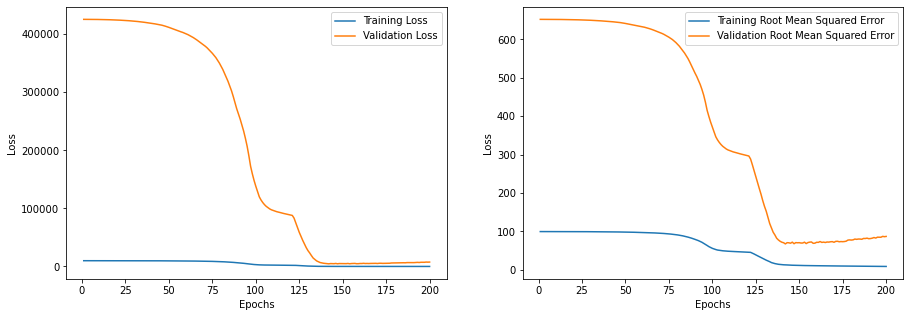

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Tesla

In [69]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

1/1 [==============================] - 0s 307ms/step


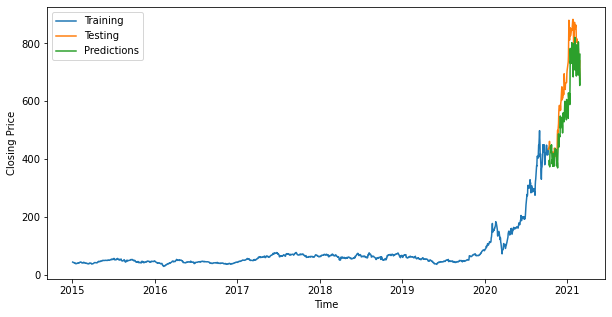

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [71]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 87.15305303489808
MAPE: 0.10549070470272846


# Google

In [35]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [73]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [74]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [75]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Model Fitting

In [76]:
GOOG_Model = Model()

In [77]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [78]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 300, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/300
10/10 [==============================] - 3s 62ms/step - loss: 1036033.1250 - root_mean_squared_error: 1017.8571 - val_loss: 3397217.2500 - val_root_mean_squared_error: 1843.1541 - lr: 0.0000e+00
Epoch 2/300
10/10 [==============================] - 0s 22ms/step - loss: 1036007.7500 - root_mean_squared_error: 1017.8446 - val_loss: 3397201.5000 - val_root_mean_squared_error: 1843.1499 - lr: 6.6667e-08
Epoch 3/300
10/10 [==============================] - 0s 22ms/step - loss: 1035923.8125 - root_mean_squared_error: 1017.8034 - val_loss: 3397162.5000 - val_root_mean_squared_error: 1843.1393 - lr: 1.3333e-07
Epoch 4/300
10/10 [==============================] - 0s 22ms/step - loss: 1035777.4375 - root_mean_squared_error: 1017.7315 - val_loss: 3397138.2500 - val_root_mean_squared_error: 1843.1327 - lr: 2.0000e-07
Epoch 5/300
10/10 [==============================] - 0s 20ms/step - loss: 1035551.7500 - root_mean_squared_error: 1017.6207 - val_loss: 3397178.7500 - val_root_mean_squared

10/10 [==============================] - 0s 20ms/step - loss: 1006514.8750 - root_mean_squared_error: 1003.2522 - val_loss: 3298874.7500 - val_root_mean_squared_error: 1816.2805 - lr: 2.6000e-06
Epoch 41/300
10/10 [==============================] - 0s 22ms/step - loss: 1005159.3125 - root_mean_squared_error: 1002.5763 - val_loss: 3294204.7500 - val_root_mean_squared_error: 1814.9944 - lr: 2.6667e-06
Epoch 42/300
10/10 [==============================] - 0s 23ms/step - loss: 1003789.3750 - root_mean_squared_error: 1001.8929 - val_loss: 3289543.5000 - val_root_mean_squared_error: 1813.7100 - lr: 2.7333e-06
Epoch 43/300
10/10 [==============================] - 0s 21ms/step - loss: 1002399.5625 - root_mean_squared_error: 1001.1990 - val_loss: 3284756.7500 - val_root_mean_squared_error: 1812.3898 - lr: 2.8000e-06
Epoch 44/300
10/10 [==============================] - 0s 21ms/step - loss: 1000960.4375 - root_mean_squared_error: 1000.4801 - val_loss: 3279571.0000 - val_root_mean_squared_error: 

Epoch 80/300
10/10 [==============================] - 0s 25ms/step - loss: 690752.1250 - root_mean_squared_error: 831.1149 - val_loss: 2218464.7500 - val_root_mean_squared_error: 1489.4512 - lr: 5.2667e-06
Epoch 81/300
10/10 [==============================] - 0s 20ms/step - loss: 663730.7500 - root_mean_squared_error: 814.6967 - val_loss: 2125945.2500 - val_root_mean_squared_error: 1458.0623 - lr: 5.3333e-06
Epoch 82/300
10/10 [==============================] - 0s 24ms/step - loss: 636401.5625 - root_mean_squared_error: 797.7477 - val_loss: 2036883.7500 - val_root_mean_squared_error: 1427.1945 - lr: 5.4000e-06
Epoch 83/300
10/10 [==============================] - 0s 25ms/step - loss: 605827.6250 - root_mean_squared_error: 778.3493 - val_loss: 1926460.3750 - val_root_mean_squared_error: 1387.9698 - lr: 5.4667e-06
Epoch 84/300
10/10 [==============================] - 0s 24ms/step - loss: 567937.2500 - root_mean_squared_error: 753.6161 - val_loss: 1809332.1250 - val_root_mean_squared_erro

10/10 [==============================] - 0s 32ms/step - loss: 14646.4023 - root_mean_squared_error: 121.0223 - val_loss: 45339.9258 - val_root_mean_squared_error: 212.9317 - lr: 7.9333e-06
Epoch 121/300
10/10 [==============================] - 0s 30ms/step - loss: 12487.4209 - root_mean_squared_error: 111.7471 - val_loss: 38143.5273 - val_root_mean_squared_error: 195.3037 - lr: 8.0000e-06
Epoch 122/300
10/10 [==============================] - 0s 32ms/step - loss: 10429.2920 - root_mean_squared_error: 102.1239 - val_loss: 34345.9375 - val_root_mean_squared_error: 185.3266 - lr: 8.0667e-06
Epoch 123/300
10/10 [==============================] - 0s 33ms/step - loss: 8791.4824 - root_mean_squared_error: 93.7629 - val_loss: 28003.4082 - val_root_mean_squared_error: 167.3422 - lr: 8.1333e-06
Epoch 124/300
10/10 [==============================] - 0s 30ms/step - loss: 7365.5215 - root_mean_squared_error: 85.8226 - val_loss: 22620.8184 - val_root_mean_squared_error: 150.4022 - lr: 8.2000e-06
Epo

10/10 [==============================] - 0s 22ms/step - loss: 704.9049 - root_mean_squared_error: 26.5500 - val_loss: 3426.9500 - val_root_mean_squared_error: 58.5402 - lr: 9.0484e-06
Epoch 162/300
10/10 [==============================] - 0s 29ms/step - loss: 729.6123 - root_mean_squared_error: 27.0113 - val_loss: 3435.6375 - val_root_mean_squared_error: 58.6143 - lr: 8.9583e-06
Epoch 163/300
10/10 [==============================] - 0s 24ms/step - loss: 711.2706 - root_mean_squared_error: 26.6697 - val_loss: 3425.7161 - val_root_mean_squared_error: 58.5296 - lr: 8.8692e-06
Epoch 164/300
10/10 [==============================] - 0s 20ms/step - loss: 697.8848 - root_mean_squared_error: 26.4175 - val_loss: 3374.3989 - val_root_mean_squared_error: 58.0896 - lr: 8.7810e-06
Epoch 165/300
10/10 [==============================] - 0s 20ms/step - loss: 696.0137 - root_mean_squared_error: 26.3821 - val_loss: 3377.7471 - val_root_mean_squared_error: 58.1184 - lr: 8.6936e-06
Epoch 166/300
10/10 [===

10/10 [==============================] - 0s 23ms/step - loss: 659.2499 - root_mean_squared_error: 25.6759 - val_loss: 3681.8518 - val_root_mean_squared_error: 60.6783 - lr: 6.0050e-06
Epoch 203/300
10/10 [==============================] - 0s 19ms/step - loss: 666.5954 - root_mean_squared_error: 25.8185 - val_loss: 3703.6865 - val_root_mean_squared_error: 60.8579 - lr: 5.9452e-06
Epoch 204/300
10/10 [==============================] - 0s 20ms/step - loss: 660.3234 - root_mean_squared_error: 25.6968 - val_loss: 3639.1743 - val_root_mean_squared_error: 60.3256 - lr: 5.8860e-06
Epoch 205/300
10/10 [==============================] - 0s 21ms/step - loss: 657.8340 - root_mean_squared_error: 25.6483 - val_loss: 3892.0459 - val_root_mean_squared_error: 62.3863 - lr: 5.8275e-06
Epoch 206/300
10/10 [==============================] - 0s 21ms/step - loss: 655.4350 - root_mean_squared_error: 25.6015 - val_loss: 3900.4287 - val_root_mean_squared_error: 62.4534 - lr: 5.7695e-06
Epoch 207/300
10/10 [===

10/10 [==============================] - 0s 20ms/step - loss: 632.0609 - root_mean_squared_error: 25.1408 - val_loss: 3743.0105 - val_root_mean_squared_error: 61.1801 - lr: 3.9852e-06
Epoch 244/300
10/10 [==============================] - 0s 19ms/step - loss: 627.5598 - root_mean_squared_error: 25.0511 - val_loss: 3828.4285 - val_root_mean_squared_error: 61.8743 - lr: 3.9455e-06
Epoch 245/300
10/10 [==============================] - 0s 24ms/step - loss: 629.5611 - root_mean_squared_error: 25.0911 - val_loss: 3938.4324 - val_root_mean_squared_error: 62.7569 - lr: 3.9063e-06
Epoch 246/300
10/10 [==============================] - 0s 23ms/step - loss: 628.4470 - root_mean_squared_error: 25.0688 - val_loss: 3822.7249 - val_root_mean_squared_error: 61.8282 - lr: 3.8674e-06
Epoch 247/300
10/10 [==============================] - 0s 28ms/step - loss: 632.0919 - root_mean_squared_error: 25.1414 - val_loss: 4006.4661 - val_root_mean_squared_error: 63.2966 - lr: 3.8289e-06
Epoch 248/300
10/10 [===

10/10 [==============================] - 0s 24ms/step - loss: 613.6501 - root_mean_squared_error: 24.7720 - val_loss: 4155.4819 - val_root_mean_squared_error: 64.4630 - lr: 2.6448e-06
Epoch 285/300
10/10 [==============================] - 0s 20ms/step - loss: 613.1228 - root_mean_squared_error: 24.7613 - val_loss: 4133.8696 - val_root_mean_squared_error: 64.2952 - lr: 2.6185e-06
Epoch 286/300
10/10 [==============================] - 0s 19ms/step - loss: 618.5545 - root_mean_squared_error: 24.8708 - val_loss: 3808.6157 - val_root_mean_squared_error: 61.7140 - lr: 2.5924e-06
Epoch 287/300
10/10 [==============================] - 0s 19ms/step - loss: 612.6954 - root_mean_squared_error: 24.7527 - val_loss: 4064.2693 - val_root_mean_squared_error: 63.7516 - lr: 2.5666e-06
Epoch 288/300
10/10 [==============================] - 0s 19ms/step - loss: 616.5258 - root_mean_squared_error: 24.8299 - val_loss: 4161.9736 - val_root_mean_squared_error: 64.5134 - lr: 2.5411e-06
Epoch 289/300
10/10 [===

In [79]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

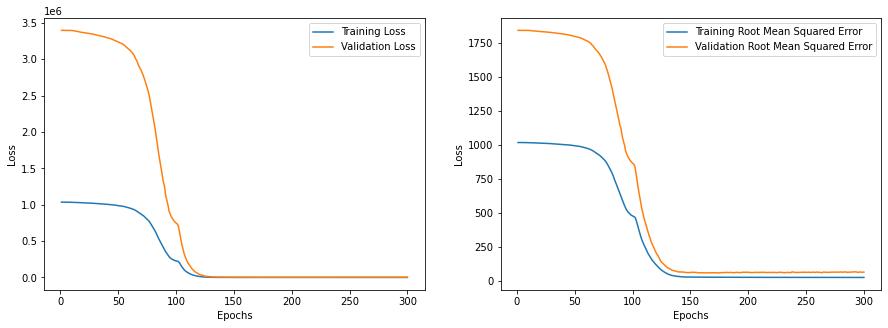

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Google

In [82]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

1/1 [==============================] - 0s 311ms/step


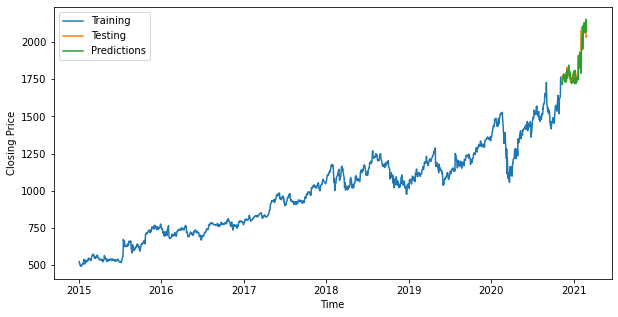

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [84]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 63.939689546988525
MAPE: 0.02321713343056624


# Microsoft

In [85]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [86]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [87]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [88]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Model Fitting

In [89]:
MSFT_Model = Model()

In [90]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [91]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 400, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

Epoch 1/400
9/9 [==============================] - 2s 63ms/step - loss: 10097.5781 - root_mean_squared_error: 100.4867 - val_loss: 45984.5898 - val_root_mean_squared_error: 214.4402 - lr: 0.0000e+00
Epoch 2/400
9/9 [==============================] - 0s 21ms/step - loss: 10097.2695 - root_mean_squared_error: 100.4852 - val_loss: 45980.5859 - val_root_mean_squared_error: 214.4308 - lr: 6.6667e-08
Epoch 3/400
9/9 [==============================] - 0s 19ms/step - loss: 10096.3086 - root_mean_squared_error: 100.4804 - val_loss: 45972.3750 - val_root_mean_squared_error: 214.4117 - lr: 1.3333e-07
Epoch 4/400
9/9 [==============================] - 0s 20ms/step - loss: 10094.6328 - root_mean_squared_error: 100.4721 - val_loss: 45960.5039 - val_root_mean_squared_error: 214.3840 - lr: 2.0000e-07
Epoch 5/400
9/9 [==============================] - 0s 21ms/step - loss: 10092.3789 - root_mean_squared_error: 100.4608 - val_loss: 45944.2422 - val_root_mean_squared_error: 214.3461 - lr: 2.6667e-07
Epoch

9/9 [==============================] - 0s 22ms/step - loss: 9473.0400 - root_mean_squared_error: 97.3295 - val_loss: 42457.0586 - val_root_mean_squared_error: 206.0511 - lr: 2.7333e-06
Epoch 43/400
9/9 [==============================] - 0s 20ms/step - loss: 9438.4082 - root_mean_squared_error: 97.1515 - val_loss: 42263.0703 - val_root_mean_squared_error: 205.5798 - lr: 2.8000e-06
Epoch 44/400
9/9 [==============================] - 0s 23ms/step - loss: 9400.6631 - root_mean_squared_error: 96.9570 - val_loss: 42065.9180 - val_root_mean_squared_error: 205.0998 - lr: 2.8667e-06
Epoch 45/400
9/9 [==============================] - 0s 20ms/step - loss: 9362.4883 - root_mean_squared_error: 96.7599 - val_loss: 41855.2305 - val_root_mean_squared_error: 204.5855 - lr: 2.9333e-06
Epoch 46/400
9/9 [==============================] - 0s 20ms/step - loss: 9323.0742 - root_mean_squared_error: 96.5561 - val_loss: 41627.9453 - val_root_mean_squared_error: 204.0293 - lr: 3.0000e-06
Epoch 47/400
9/9 [=====

9/9 [==============================] - 0s 24ms/step - loss: 3875.6372 - root_mean_squared_error: 62.2546 - val_loss: 15414.7061 - val_root_mean_squared_error: 124.1560 - lr: 5.4667e-06
Epoch 84/400
9/9 [==============================] - 0s 20ms/step - loss: 3591.6284 - root_mean_squared_error: 59.9302 - val_loss: 14400.9688 - val_root_mean_squared_error: 120.0040 - lr: 5.5333e-06
Epoch 85/400
9/9 [==============================] - 0s 17ms/step - loss: 3346.1611 - root_mean_squared_error: 57.8460 - val_loss: 13615.7471 - val_root_mean_squared_error: 116.6865 - lr: 5.6000e-06
Epoch 86/400
9/9 [==============================] - 0s 28ms/step - loss: 3150.5891 - root_mean_squared_error: 56.1301 - val_loss: 12962.8291 - val_root_mean_squared_error: 113.8544 - lr: 5.6667e-06
Epoch 87/400
9/9 [==============================] - 0s 18ms/step - loss: 2978.3616 - root_mean_squared_error: 54.5744 - val_loss: 12423.4053 - val_root_mean_squared_error: 111.4603 - lr: 5.7333e-06
Epoch 88/400
9/9 [=====

9/9 [==============================] - 0s 22ms/step - loss: 18.1627 - root_mean_squared_error: 4.2618 - val_loss: 55.6381 - val_root_mean_squared_error: 7.4591 - lr: 8.2667e-06
Epoch 126/400
9/9 [==============================] - 0s 27ms/step - loss: 18.0505 - root_mean_squared_error: 4.2486 - val_loss: 55.6758 - val_root_mean_squared_error: 7.4616 - lr: 8.3333e-06
Epoch 127/400
9/9 [==============================] - 0s 22ms/step - loss: 17.8455 - root_mean_squared_error: 4.2244 - val_loss: 55.9691 - val_root_mean_squared_error: 7.4812 - lr: 8.4000e-06
Epoch 128/400
9/9 [==============================] - 0s 20ms/step - loss: 17.7260 - root_mean_squared_error: 4.2102 - val_loss: 55.2683 - val_root_mean_squared_error: 7.4343 - lr: 8.4667e-06
Epoch 129/400
9/9 [==============================] - 0s 26ms/step - loss: 17.7015 - root_mean_squared_error: 4.2073 - val_loss: 56.2668 - val_root_mean_squared_error: 7.5011 - lr: 8.5333e-06
Epoch 130/400
9/9 [==============================] - 0s 21m

Epoch 168/400
9/9 [==============================] - 0s 17ms/step - loss: 15.5008 - root_mean_squared_error: 3.9371 - val_loss: 52.1598 - val_root_mean_squared_error: 7.2222 - lr: 8.4366e-06
Epoch 169/400
9/9 [==============================] - 0s 18ms/step - loss: 15.4842 - root_mean_squared_error: 3.9350 - val_loss: 53.0905 - val_root_mean_squared_error: 7.2863 - lr: 8.3527e-06
Epoch 170/400
9/9 [==============================] - 0s 18ms/step - loss: 15.4666 - root_mean_squared_error: 3.9328 - val_loss: 52.5587 - val_root_mean_squared_error: 7.2497 - lr: 8.2696e-06
Epoch 171/400
9/9 [==============================] - 0s 17ms/step - loss: 15.4554 - root_mean_squared_error: 3.9313 - val_loss: 52.0600 - val_root_mean_squared_error: 7.2153 - lr: 8.1873e-06
Epoch 172/400
9/9 [==============================] - 0s 18ms/step - loss: 15.4370 - root_mean_squared_error: 3.9290 - val_loss: 52.4969 - val_root_mean_squared_error: 7.2455 - lr: 8.1058e-06
Epoch 173/400
9/9 [==========================

Epoch 211/400
9/9 [==============================] - 0s 22ms/step - loss: 14.9052 - root_mean_squared_error: 3.8607 - val_loss: 50.7349 - val_root_mean_squared_error: 7.1228 - lr: 5.4881e-06
Epoch 212/400
9/9 [==============================] - 0s 17ms/step - loss: 14.8562 - root_mean_squared_error: 3.8544 - val_loss: 51.7868 - val_root_mean_squared_error: 7.1963 - lr: 5.4335e-06
Epoch 213/400
9/9 [==============================] - 0s 19ms/step - loss: 14.8334 - root_mean_squared_error: 3.8514 - val_loss: 51.1398 - val_root_mean_squared_error: 7.1512 - lr: 5.3794e-06
Epoch 214/400
9/9 [==============================] - 0s 17ms/step - loss: 14.7968 - root_mean_squared_error: 3.8467 - val_loss: 51.5434 - val_root_mean_squared_error: 7.1794 - lr: 5.3259e-06
Epoch 215/400
9/9 [==============================] - 0s 17ms/step - loss: 14.7784 - root_mean_squared_error: 3.8443 - val_loss: 51.9884 - val_root_mean_squared_error: 7.2103 - lr: 5.2729e-06
Epoch 216/400
9/9 [==========================

Epoch 254/400
9/9 [==============================] - 0s 21ms/step - loss: 14.2962 - root_mean_squared_error: 3.7810 - val_loss: 50.2877 - val_root_mean_squared_error: 7.0914 - lr: 3.5701e-06
Epoch 255/400
9/9 [==============================] - 0s 17ms/step - loss: 14.2868 - root_mean_squared_error: 3.7798 - val_loss: 50.3300 - val_root_mean_squared_error: 7.0944 - lr: 3.5345e-06
Epoch 256/400
9/9 [==============================] - 0s 16ms/step - loss: 14.2886 - root_mean_squared_error: 3.7800 - val_loss: 50.3228 - val_root_mean_squared_error: 7.0939 - lr: 3.4994e-06
Epoch 257/400
9/9 [==============================] - 0s 20ms/step - loss: 14.2590 - root_mean_squared_error: 3.7761 - val_loss: 49.9683 - val_root_mean_squared_error: 7.0688 - lr: 3.4646e-06
Epoch 258/400
9/9 [==============================] - 0s 17ms/step - loss: 14.2584 - root_mean_squared_error: 3.7760 - val_loss: 49.6136 - val_root_mean_squared_error: 7.0437 - lr: 3.4301e-06
Epoch 259/400
9/9 [==========================

Epoch 297/400
9/9 [==============================] - 0s 17ms/step - loss: 13.9760 - root_mean_squared_error: 3.7385 - val_loss: 49.7404 - val_root_mean_squared_error: 7.0527 - lr: 2.3224e-06
Epoch 298/400
9/9 [==============================] - 0s 18ms/step - loss: 13.9708 - root_mean_squared_error: 3.7377 - val_loss: 49.7931 - val_root_mean_squared_error: 7.0564 - lr: 2.2993e-06
Epoch 299/400
9/9 [==============================] - 0s 18ms/step - loss: 13.9572 - root_mean_squared_error: 3.7359 - val_loss: 50.0419 - val_root_mean_squared_error: 7.0740 - lr: 2.2764e-06
Epoch 300/400
9/9 [==============================] - 0s 15ms/step - loss: 13.9567 - root_mean_squared_error: 3.7359 - val_loss: 49.8994 - val_root_mean_squared_error: 7.0640 - lr: 2.2537e-06
Epoch 301/400
9/9 [==============================] - 0s 16ms/step - loss: 13.9444 - root_mean_squared_error: 3.7342 - val_loss: 50.1298 - val_root_mean_squared_error: 7.0802 - lr: 2.2313e-06
Epoch 302/400
9/9 [==========================

Epoch 340/400
9/9 [==============================] - 0s 16ms/step - loss: 13.7329 - root_mean_squared_error: 3.7058 - val_loss: 50.2027 - val_root_mean_squared_error: 7.0854 - lr: 1.5107e-06
Epoch 341/400
9/9 [==============================] - 0s 21ms/step - loss: 13.7266 - root_mean_squared_error: 3.7049 - val_loss: 50.0327 - val_root_mean_squared_error: 7.0734 - lr: 1.4957e-06
Epoch 342/400
9/9 [==============================] - 0s 22ms/step - loss: 13.7275 - root_mean_squared_error: 3.7051 - val_loss: 50.1913 - val_root_mean_squared_error: 7.0846 - lr: 1.4808e-06
Epoch 343/400
9/9 [==============================] - 0s 23ms/step - loss: 13.7169 - root_mean_squared_error: 3.7036 - val_loss: 50.1211 - val_root_mean_squared_error: 7.0796 - lr: 1.4661e-06
Epoch 344/400
9/9 [==============================] - 0s 19ms/step - loss: 13.7271 - root_mean_squared_error: 3.7050 - val_loss: 50.3677 - val_root_mean_squared_error: 7.0970 - lr: 1.4515e-06
Epoch 345/400
9/9 [==========================

Epoch 383/400
9/9 [==============================] - 0s 24ms/step - loss: 13.5649 - root_mean_squared_error: 3.6831 - val_loss: 50.2473 - val_root_mean_squared_error: 7.0885 - lr: 9.8274e-07
Epoch 384/400
9/9 [==============================] - 0s 21ms/step - loss: 13.5718 - root_mean_squared_error: 3.6840 - val_loss: 49.7068 - val_root_mean_squared_error: 7.0503 - lr: 9.7296e-07
Epoch 385/400
9/9 [==============================] - 0s 17ms/step - loss: 13.5484 - root_mean_squared_error: 3.6808 - val_loss: 49.7720 - val_root_mean_squared_error: 7.0549 - lr: 9.6328e-07
Epoch 386/400
9/9 [==============================] - 0s 16ms/step - loss: 13.5449 - root_mean_squared_error: 3.6803 - val_loss: 49.9262 - val_root_mean_squared_error: 7.0658 - lr: 9.5369e-07
Epoch 387/400
9/9 [==============================] - 0s 16ms/step - loss: 13.5527 - root_mean_squared_error: 3.6814 - val_loss: 50.2450 - val_root_mean_squared_error: 7.0884 - lr: 9.4420e-07
Epoch 388/400
9/9 [==========================

In [92]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

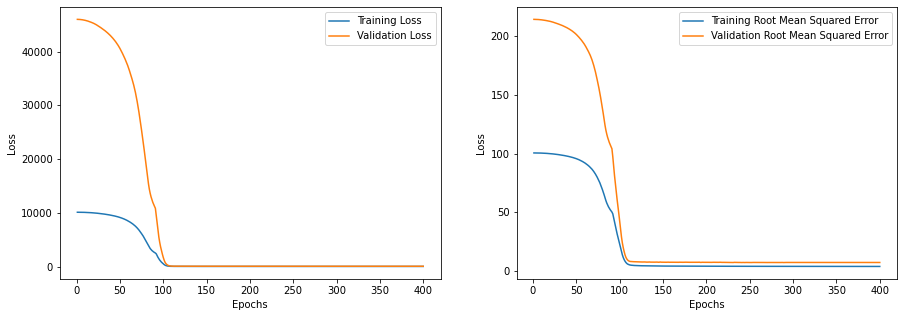

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Microsoft

In [94]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

1/1 [==============================] - 1s 612ms/step


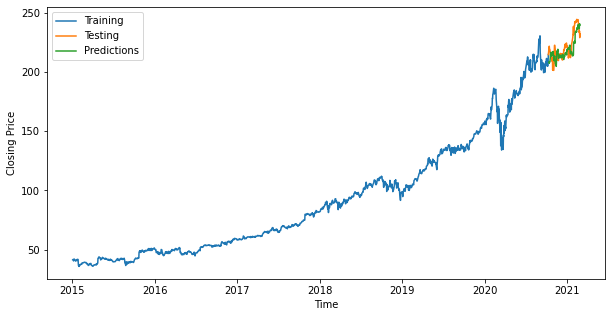

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [96]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 7.057174914413999
MAPE: 0.025328126455546537


# Amazon

In [97]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [98]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [99]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [100]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Model Fitting

In [101]:
AMZN_Model = Model()

In [102]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [103]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 500, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

Epoch 1/500
10/10 [==============================] - 4s 66ms/step - loss: 2263322.7500 - root_mean_squared_error: 1504.4343 - val_loss: 10115860.0000 - val_root_mean_squared_error: 3180.5439 - lr: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 28ms/step - loss: 2263293.2500 - root_mean_squared_error: 1504.4244 - val_loss: 10115463.0000 - val_root_mean_squared_error: 3180.4817 - lr: 6.6667e-08
Epoch 3/500
10/10 [==============================] - 0s 28ms/step - loss: 2263206.2500 - root_mean_squared_error: 1504.3955 - val_loss: 10114672.0000 - val_root_mean_squared_error: 3180.3574 - lr: 1.3333e-07
Epoch 4/500
10/10 [==============================] - 0s 27ms/step - loss: 2263044.5000 - root_mean_squared_error: 1504.3418 - val_loss: 10113641.0000 - val_root_mean_squared_error: 3180.1953 - lr: 2.0000e-07
Epoch 5/500
10/10 [==============================] - 0s 23ms/step - loss: 2262823.5000 - root_mean_squared_error: 1504.2684 - val_loss: 10112470.0000 - val_root_mean_sq

10/10 [==============================] - 0s 22ms/step - loss: 2202595.5000 - root_mean_squared_error: 1484.1144 - val_loss: 9822944.0000 - val_root_mean_squared_error: 3134.1577 - lr: 2.6000e-06
Epoch 41/500
10/10 [==============================] - 0s 23ms/step - loss: 2199878.2500 - root_mean_squared_error: 1483.1986 - val_loss: 9809338.0000 - val_root_mean_squared_error: 3131.9861 - lr: 2.6667e-06
Epoch 42/500
10/10 [==============================] - 0s 19ms/step - loss: 2196869.7500 - root_mean_squared_error: 1482.1841 - val_loss: 9796788.0000 - val_root_mean_squared_error: 3129.9822 - lr: 2.7333e-06
Epoch 43/500
10/10 [==============================] - 0s 16ms/step - loss: 2193817.0000 - root_mean_squared_error: 1481.1541 - val_loss: 9784193.0000 - val_root_mean_squared_error: 3127.9695 - lr: 2.8000e-06
Epoch 44/500
10/10 [==============================] - 0s 22ms/step - loss: 2190596.2500 - root_mean_squared_error: 1480.0663 - val_loss: 9770695.0000 - val_root_mean_squared_error: 

10/10 [==============================] - 0s 35ms/step - loss: 1921359.7500 - root_mean_squared_error: 1386.1312 - val_loss: 8539182.0000 - val_root_mean_squared_error: 2922.1880 - lr: 5.2000e-06
Epoch 80/500
10/10 [==============================] - 0s 40ms/step - loss: 1905296.2500 - root_mean_squared_error: 1380.3247 - val_loss: 8466468.0000 - val_root_mean_squared_error: 2909.7195 - lr: 5.2667e-06
Epoch 81/500
10/10 [==============================] - 0s 38ms/step - loss: 1882777.2500 - root_mean_squared_error: 1372.1433 - val_loss: 8342357.5000 - val_root_mean_squared_error: 2888.3140 - lr: 5.3333e-06
Epoch 82/500
10/10 [==============================] - 0s 27ms/step - loss: 1858791.5000 - root_mean_squared_error: 1363.3751 - val_loss: 8212805.5000 - val_root_mean_squared_error: 2865.7993 - lr: 5.4000e-06
Epoch 83/500
10/10 [==============================] - 0s 24ms/step - loss: 1831607.5000 - root_mean_squared_error: 1353.3690 - val_loss: 8106188.5000 - val_root_mean_squared_error: 

10/10 [==============================] - 0s 25ms/step - loss: 580602.9375 - root_mean_squared_error: 761.9731 - val_loss: 2353724.2500 - val_root_mean_squared_error: 1534.1852 - lr: 7.8000e-06
Epoch 119/500
10/10 [==============================] - 0s 27ms/step - loss: 506398.5312 - root_mean_squared_error: 711.6169 - val_loss: 2045745.6250 - val_root_mean_squared_error: 1430.2957 - lr: 7.8667e-06
Epoch 120/500
10/10 [==============================] - 0s 23ms/step - loss: 439102.9375 - root_mean_squared_error: 662.6484 - val_loss: 1775686.3750 - val_root_mean_squared_error: 1332.5488 - lr: 7.9333e-06
Epoch 121/500
10/10 [==============================] - 0s 24ms/step - loss: 380277.2812 - root_mean_squared_error: 616.6663 - val_loss: 1536082.7500 - val_root_mean_squared_error: 1239.3881 - lr: 8.0000e-06
Epoch 122/500
10/10 [==============================] - 0s 21ms/step - loss: 328965.7500 - root_mean_squared_error: 573.5554 - val_loss: 1290980.5000 - val_root_mean_squared_error: 1136.2

10/10 [==============================] - 0s 25ms/step - loss: 3371.0496 - root_mean_squared_error: 58.0607 - val_loss: 9341.3252 - val_root_mean_squared_error: 96.6505 - lr: 9.3239e-06
Epoch 159/500
10/10 [==============================] - 0s 24ms/step - loss: 3361.3926 - root_mean_squared_error: 57.9775 - val_loss: 8700.8262 - val_root_mean_squared_error: 93.2782 - lr: 9.2312e-06
Epoch 160/500
10/10 [==============================] - 0s 24ms/step - loss: 3284.9919 - root_mean_squared_error: 57.3148 - val_loss: 9964.4561 - val_root_mean_squared_error: 99.8221 - lr: 9.1393e-06
Epoch 161/500
10/10 [==============================] - 0s 24ms/step - loss: 3315.2112 - root_mean_squared_error: 57.5779 - val_loss: 10506.1787 - val_root_mean_squared_error: 102.4997 - lr: 9.0484e-06
Epoch 162/500
10/10 [==============================] - 0s 20ms/step - loss: 3178.9163 - root_mean_squared_error: 56.3819 - val_loss: 8572.1260 - val_root_mean_squared_error: 92.5858 - lr: 8.9583e-06
Epoch 163/500
10/

10/10 [==============================] - 0s 25ms/step - loss: 2774.3713 - root_mean_squared_error: 52.6723 - val_loss: 9890.9941 - val_root_mean_squared_error: 99.4535 - lr: 6.1878e-06
Epoch 200/500
10/10 [==============================] - 0s 23ms/step - loss: 2791.7754 - root_mean_squared_error: 52.8373 - val_loss: 10346.1162 - val_root_mean_squared_error: 101.7159 - lr: 6.1263e-06
Epoch 201/500
10/10 [==============================] - 0s 22ms/step - loss: 2822.7327 - root_mean_squared_error: 53.1294 - val_loss: 7885.2017 - val_root_mean_squared_error: 88.7987 - lr: 6.0653e-06
Epoch 202/500
10/10 [==============================] - 0s 22ms/step - loss: 2758.7083 - root_mean_squared_error: 52.5234 - val_loss: 10200.4648 - val_root_mean_squared_error: 100.9973 - lr: 6.0050e-06
Epoch 203/500
10/10 [==============================] - 0s 22ms/step - loss: 2770.3601 - root_mean_squared_error: 52.6342 - val_loss: 8757.1230 - val_root_mean_squared_error: 93.5795 - lr: 5.9452e-06
Epoch 204/500
1

10/10 [==============================] - 0s 23ms/step - loss: 2601.7410 - root_mean_squared_error: 51.0073 - val_loss: 6957.8896 - val_root_mean_squared_error: 83.4140 - lr: 4.1066e-06
Epoch 241/500
10/10 [==============================] - 0s 24ms/step - loss: 2591.7180 - root_mean_squared_error: 50.9089 - val_loss: 7159.1577 - val_root_mean_squared_error: 84.6118 - lr: 4.0657e-06
Epoch 242/500
10/10 [==============================] - 0s 22ms/step - loss: 2601.2268 - root_mean_squared_error: 51.0022 - val_loss: 7104.4746 - val_root_mean_squared_error: 84.2880 - lr: 4.0252e-06
Epoch 243/500
10/10 [==============================] - 0s 22ms/step - loss: 2614.0840 - root_mean_squared_error: 51.1281 - val_loss: 7025.2808 - val_root_mean_squared_error: 83.8169 - lr: 3.9852e-06
Epoch 244/500
10/10 [==============================] - 0s 20ms/step - loss: 2591.0439 - root_mean_squared_error: 50.9023 - val_loss: 6853.6479 - val_root_mean_squared_error: 82.7868 - lr: 3.9455e-06
Epoch 245/500
10/10

10/10 [==============================] - 0s 25ms/step - loss: 2493.6831 - root_mean_squared_error: 49.9368 - val_loss: 8799.8076 - val_root_mean_squared_error: 93.8073 - lr: 2.7253e-06
Epoch 282/500
10/10 [==============================] - 0s 23ms/step - loss: 2483.6382 - root_mean_squared_error: 49.8361 - val_loss: 7806.0542 - val_root_mean_squared_error: 88.3519 - lr: 2.6982e-06
Epoch 283/500
10/10 [==============================] - 0s 24ms/step - loss: 2491.6362 - root_mean_squared_error: 49.9163 - val_loss: 8535.0977 - val_root_mean_squared_error: 92.3856 - lr: 2.6714e-06
Epoch 284/500
10/10 [==============================] - 0s 25ms/step - loss: 2478.7036 - root_mean_squared_error: 49.7866 - val_loss: 8376.7275 - val_root_mean_squared_error: 91.5245 - lr: 2.6448e-06
Epoch 285/500
10/10 [==============================] - 0s 23ms/step - loss: 2475.6748 - root_mean_squared_error: 49.7561 - val_loss: 9327.5664 - val_root_mean_squared_error: 96.5793 - lr: 2.6185e-06
Epoch 286/500
10/10

10/10 [==============================] - 0s 33ms/step - loss: 2455.0068 - root_mean_squared_error: 49.5480 - val_loss: 7325.9927 - val_root_mean_squared_error: 85.5920 - lr: 1.8087e-06
Epoch 323/500
10/10 [==============================] - 0s 38ms/step - loss: 2446.4155 - root_mean_squared_error: 49.4613 - val_loss: 7405.0693 - val_root_mean_squared_error: 86.0527 - lr: 1.7907e-06
Epoch 324/500
10/10 [==============================] - 0s 39ms/step - loss: 2450.7261 - root_mean_squared_error: 49.5048 - val_loss: 7748.6138 - val_root_mean_squared_error: 88.0262 - lr: 1.7728e-06
Epoch 325/500
10/10 [==============================] - 0s 32ms/step - loss: 2444.4385 - root_mean_squared_error: 49.4413 - val_loss: 7267.8101 - val_root_mean_squared_error: 85.2514 - lr: 1.7552e-06
Epoch 326/500
10/10 [==============================] - 0s 33ms/step - loss: 2444.1284 - root_mean_squared_error: 49.4381 - val_loss: 7016.1333 - val_root_mean_squared_error: 83.7624 - lr: 1.7377e-06
Epoch 327/500
10/10

10/10 [==============================] - 0s 31ms/step - loss: 2399.6570 - root_mean_squared_error: 48.9863 - val_loss: 7465.7124 - val_root_mean_squared_error: 86.4044 - lr: 1.2003e-06
Epoch 364/500
10/10 [==============================] - 0s 28ms/step - loss: 2401.7493 - root_mean_squared_error: 49.0076 - val_loss: 7318.9512 - val_root_mean_squared_error: 85.5509 - lr: 1.1884e-06
Epoch 365/500
10/10 [==============================] - 0s 32ms/step - loss: 2396.6958 - root_mean_squared_error: 48.9561 - val_loss: 7694.6001 - val_root_mean_squared_error: 87.7189 - lr: 1.1765e-06
Epoch 366/500
10/10 [==============================] - 0s 27ms/step - loss: 2398.4683 - root_mean_squared_error: 48.9742 - val_loss: 7686.6338 - val_root_mean_squared_error: 87.6735 - lr: 1.1648e-06
Epoch 367/500
10/10 [==============================] - 0s 28ms/step - loss: 2395.6079 - root_mean_squared_error: 48.9450 - val_loss: 7734.1313 - val_root_mean_squared_error: 87.9439 - lr: 1.1533e-06
Epoch 368/500
10/10

10/10 [==============================] - 0s 28ms/step - loss: 2371.6294 - root_mean_squared_error: 48.6994 - val_loss: 8169.3984 - val_root_mean_squared_error: 90.3847 - lr: 1.0000e-06
Epoch 405/500
10/10 [==============================] - 0s 24ms/step - loss: 2373.0610 - root_mean_squared_error: 48.7141 - val_loss: 8386.7773 - val_root_mean_squared_error: 91.5794 - lr: 1.0000e-06
Epoch 406/500
10/10 [==============================] - 0s 27ms/step - loss: 2372.6211 - root_mean_squared_error: 48.7096 - val_loss: 8591.6748 - val_root_mean_squared_error: 92.6913 - lr: 1.0000e-06
Epoch 407/500
10/10 [==============================] - 0s 29ms/step - loss: 2366.5000 - root_mean_squared_error: 48.6467 - val_loss: 8284.1738 - val_root_mean_squared_error: 91.0174 - lr: 1.0000e-06
Epoch 408/500
10/10 [==============================] - 0s 29ms/step - loss: 2371.6604 - root_mean_squared_error: 48.6997 - val_loss: 8075.5532 - val_root_mean_squared_error: 89.8641 - lr: 1.0000e-06
Epoch 409/500
10/10

10/10 [==============================] - 0s 50ms/step - loss: 2347.4746 - root_mean_squared_error: 48.4507 - val_loss: 8210.8809 - val_root_mean_squared_error: 90.6139 - lr: 1.0000e-06
Epoch 446/500
10/10 [==============================] - 1s 53ms/step - loss: 2348.9639 - root_mean_squared_error: 48.4661 - val_loss: 8321.7227 - val_root_mean_squared_error: 91.2235 - lr: 1.0000e-06
Epoch 447/500
10/10 [==============================] - 0s 44ms/step - loss: 2349.1541 - root_mean_squared_error: 48.4681 - val_loss: 7869.6138 - val_root_mean_squared_error: 88.7108 - lr: 1.0000e-06
Epoch 448/500
10/10 [==============================] - 0s 45ms/step - loss: 2348.5083 - root_mean_squared_error: 48.4614 - val_loss: 8481.5449 - val_root_mean_squared_error: 92.0953 - lr: 1.0000e-06
Epoch 449/500
10/10 [==============================] - 0s 37ms/step - loss: 2345.7397 - root_mean_squared_error: 48.4328 - val_loss: 8648.9023 - val_root_mean_squared_error: 92.9995 - lr: 1.0000e-06
Epoch 450/500
10/10

10/10 [==============================] - 0s 21ms/step - loss: 2321.6260 - root_mean_squared_error: 48.1833 - val_loss: 8970.3506 - val_root_mean_squared_error: 94.7119 - lr: 1.0000e-06
Epoch 487/500
10/10 [==============================] - 0s 41ms/step - loss: 2332.5449 - root_mean_squared_error: 48.2964 - val_loss: 8047.4785 - val_root_mean_squared_error: 89.7077 - lr: 1.0000e-06
Epoch 488/500
10/10 [==============================] - 0s 20ms/step - loss: 2324.9045 - root_mean_squared_error: 48.2173 - val_loss: 9164.8760 - val_root_mean_squared_error: 95.7334 - lr: 1.0000e-06
Epoch 489/500
10/10 [==============================] - 0s 23ms/step - loss: 2318.5791 - root_mean_squared_error: 48.1516 - val_loss: 9334.3555 - val_root_mean_squared_error: 96.6145 - lr: 1.0000e-06
Epoch 490/500
10/10 [==============================] - 0s 20ms/step - loss: 2322.9915 - root_mean_squared_error: 48.1974 - val_loss: 9167.6191 - val_root_mean_squared_error: 95.7477 - lr: 1.0000e-06
Epoch 491/500
10/10

In [104]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

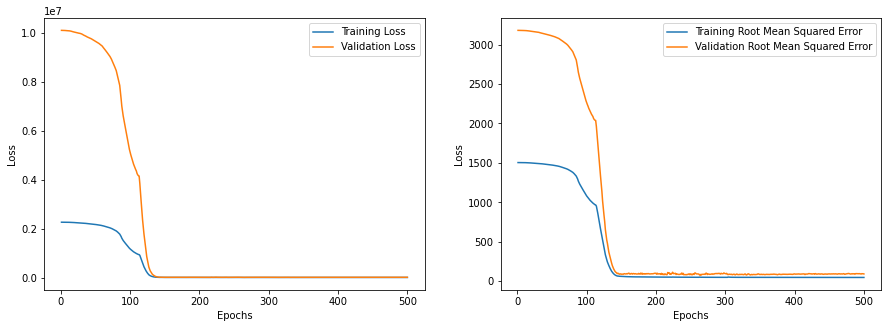

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Amazon

In [106]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

1/1 [==============================] - 1s 504ms/step


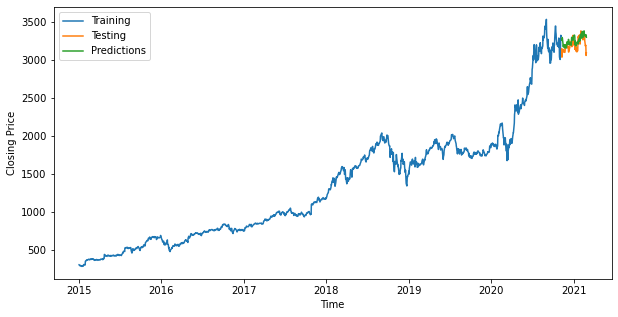

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [109]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 92.44126746074743
MAPE: 0.023249665029466585
